# TME 2

## 1. Introduction

In [10]:
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import numpy as np

plt.rcParams['font.family'] = 'Helvetica'


In [11]:
M1 = np.array([[0,8,7,12], [8,0,9,14], [7,9,0,11], [12,14,11,0]])
M2 = np.array([[0,2,3,8,14,18],[2,0,3,8,14,18],
      [3,3,0,8,14,18],[8,8,8,0,14,18],
      [14,14,14,14,0,18],[18,18,18,18,18,0]])
#UPGMA
M3 = np.array([[0,19,27,8,33,18,13],[19,0,31,18,36,1,13],
          [27,31,0,26,41,32,29],[8,18,26,0,31,17,14],
          [33,36,41,31,0,35,28],[18,1,32,17,35,0,12],
          [13,13,29,14,28,12,0]])
#Neighbor Joining
M4 = np.array([[0,2,4,6,6,8],[2,0,4,6,6,8],
          [4,4,0,6,6,8],[6,6,6,0,4,8],
          [6,6,6,4,0,8],[8,8,8,8,8,0]])


In [12]:
def is_additive(matrix: np.ndarray):
  for a in range(len(matrix)):
    for b in range(a):
      for c in range(b):
        for d in range(c):
          x = matrix[a, b] + matrix[c, d]
          y = matrix[a, d] + matrix[b, c]
          z = matrix[a, c] + matrix[b, d]

          if not (x >= z and y >= z) and not (x >= y and z >= y) and not (y >= x and z >= x):
            return False

  return True


print(is_additive(M1))
print(is_additive(M2))
print(is_additive(M3))
print(is_additive(M4))


True
True
True
True


In [13]:
def is_ultrametric(matrix: np.ndarray):
  for a in range(len(matrix)):
    for b in range(a):
      for c in range(b):
        if matrix[a, c] > max(matrix[a, b], matrix[b, c]):
          return False

  return True

print(is_ultrametric(M1))
print(is_ultrametric(M2))
print(is_ultrametric(M3))
print(is_ultrametric(M4))


False
True
False
True


## 2. UPGMA

In [14]:
# Utilities for building and drawing trees

from dataclasses import dataclass
from typing import Self

@dataclass
class Leaf:
  value: int

@dataclass
class Node:
  children: list[tuple[Self | Leaf, float]]

  def _newick(self) -> str:
    return '(' + ','.join([(chr(ord('A') + child.value) if isinstance(child, Leaf) else child._newick()) + f':{dist:.2f}' for child, dist in self.children]) + ')'

  def newick(self):
    return self._newick() + ';'

  def draw(self):
    fig, ax = plt.subplots()

    ax.get_yaxis().set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

    @dataclass
    class NodeMarker:
      node: Node
      x: float

      current_child_index: int = 0
      y_start: float = 0.0
      y_end: float = 0.0

    pointer = [NodeMarker(self, 0.0)]
    leaf_vertical_padding = 0.1

    current_y = 0.0
    max_x = 0.0

    while pointer:
      marker = pointer[-1]

      if marker.current_child_index >= len(marker.node.children):
        pointer.pop()
        ax.add_line(Line2D([marker.x, marker.x], [marker.y_start, marker.y_end], color='k'))

        if pointer:
          marker_y_mid = (marker.y_start + marker.y_end) * 0.5
          prev_marker = pointer[-1]

          if prev_marker.current_child_index == 0:
            prev_marker.y_start = marker_y_mid

          prev_marker.y_end = marker_y_mid
          prev_marker.current_child_index += 1

          ax.add_line(Line2D([prev_marker.x, marker.x], [marker_y_mid, marker_y_mid], color='k'))
      else:
        child_node, child_dist = marker.node.children[marker.current_child_index]

        match child_node:
          case Leaf():
            current_y += leaf_vertical_padding

            if marker.current_child_index == 0:
              marker.y_start = current_y

            leaf_x = marker.x + child_dist
            max_x = max(max_x, marker.x + child_dist)

            ax.add_line(Line2D([marker.x, marker.x + child_dist], [current_y, current_y], color='k'))
            ax.text(leaf_x + 0.05, current_y, chr(ord('A') + child_node.value), verticalalignment='center')

            marker.current_child_index += 1
            marker.y_end = current_y
            current_y += leaf_vertical_padding
          case Node():
            pointer.append(NodeMarker(child_node, marker.x + child_dist))

    ax.set_xlim(-0.1, max_x + 0.15)
    ax.set_ylim(current_y, 0.0)

    bottom_height = 0.4
    total_height = current_y * 2.0 + bottom_height

    fig.set_size_inches(5.0, total_height)
    fig.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=(bottom_height / total_height))

    return fig, ax


In [15]:
from typing import cast

def upgma(matrix: np.ndarray):
  n = len(matrix)
  clusters = [[i] for i in range(n)]
  dist =[[matrix[i, j] for j in range(n)] for i in range(n)]
  nodes: list[tuple[Leaf | Node, float]] = [(Leaf(i), 0.0) for i in range(n)]

  while n > 1:
    # Find the minimum distance
    min_dist = np.inf
    min_i = -1
    min_j = -1

    for i in range(n):
      for j in range(i):
        if dist[i][j] < min_dist:
          min_dist = dist[i][j]
          min_i = i
          min_j = j

    # Create the new cluster
    new_cluster = clusters[min_i] + clusters[min_j]
    last_cluster_i= clusters[min_i]
    last_cluster_j= clusters[min_j]

    # Update tree nodes
    nodes.append(
      (Node([
        (nodes[min_i][0], min_dist * 0.5 - nodes[min_i][1]),
        (nodes[min_j][0], min_dist * 0.5 - nodes[min_j][1])
      ]), min_dist * 0.5)
    )

    nodes.pop(max(min_i, min_j))
    nodes.pop(min(min_i, min_j))

    # Update the clusters
    clusters.pop(max(min_i, min_j))
    clusters.pop(min(min_i, min_j))
    clusters.append(new_cluster)


    # Update the distance matrix
    new_dist = dist
    for i in range(n):
      if i!=min_i and i!=min_j:
       new_dist[i].append((dist[min_i][i] * len(last_cluster_i) + dist[min_j][i] * len(last_cluster_j)) / (len(last_cluster_i) + len(last_cluster_j)))
    new_dist.append([])
    for i in range(n):
      if i!=min_i and i!=min_j:
       new_dist[n].append((dist[min_i][i] * len(last_cluster_i) + dist[min_j][i] * len(last_cluster_j)) / (len(last_cluster_i) + len(last_cluster_j)))
    new_dist[n].append(0)
    new_dist.pop(max(min_i, min_j))
    new_dist.pop(min(min_i, min_j))
    for i in range(n-2):
      del new_dist[i][max(min_i, min_j)]
      del new_dist[i][min(min_i, min_j)]
    dist = new_dist
    n -= 1

  return cast(Node, nodes[0][0])


(((((B:1.00,A:1.00):0.50,C:1.50):2.50,D:4.00):3.00,E:7.00):2.00,F:9.00);
((((B:1.00,A:1.00):1.00,C:2.00):1.00,(E:2.00,D:2.00):1.00):1.00,F:4.00);


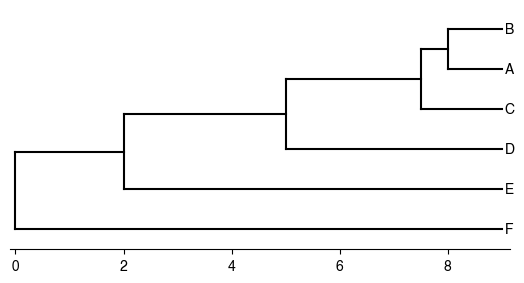

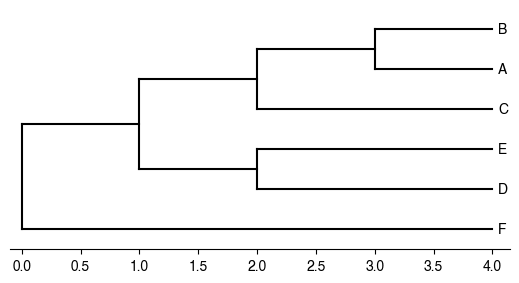

In [16]:
for matrix in [M1, M2, M3, M4]:
  if is_ultrametric(matrix):
    tree = upgma(matrix)
    print(tree.newick())
    fig, ax = tree.draw()


## 3. Neighbor Joining

In [17]:
def nj(matrix: np.ndarray):
  m = matrix.astype(np.float64)
  clusters: list[Node | Leaf] = [Leaf(i) for i in range(len(m))]

  while (n := len(m)) > 2:
    q: np.ndarray = (n - 2) * m - m.sum(axis=0) - m.sum(axis=1, keepdims=True)
    q[np.diag_indices_from(q)] = np.inf

    a, b = np.unravel_index(q.argmin(), q.shape)
    a = int(a)
    b = int(b)

    da = 0.5 * m[a, b] + 0.5 / (n - 2) * (m[a, :].sum() - m[b, :].sum())
    db = m[a, b] - da

    clusters.append(Node([
      (clusters[a], da),
      (clusters[b], db)
    ]))

    del clusters[max(a, b)]
    del clusters[min(a, b)]

    new_row = 0.5 * (m[a, :] + m[b, :] - m[a, b])

    indices = [i for i in range(n) if i != a and i != b]
    m = m[indices, :][:, indices]
    m = np.pad(m, (0, 1))

    m[0:-1, -1] = new_row[indices]
    m[-1, 0:-1] = new_row[indices]

  return Node([
    (clusters[0], m[0, 1] * 0.5),
    (clusters[1], m[0, 1] * 0.5)
  ])


((A:3.00,B:5.00):0.50,(C:3.00,D:8.00):0.50);
((A:1.00,B:1.00):0.25,(C:1.50,(D:4.00,(E:7.00,F:11.00):3.00):2.50):0.25);
((C:18.75,E:22.25):0.88,((A:4.38,D:3.62):3.00,(G:3.83,(B:0.80,F:0.20):8.17):2.50):0.88);
((D:2.00,E:2.00):0.50,(F:5.00,(C:2.00,(A:1.00,B:1.00):1.00):1.00):0.50);


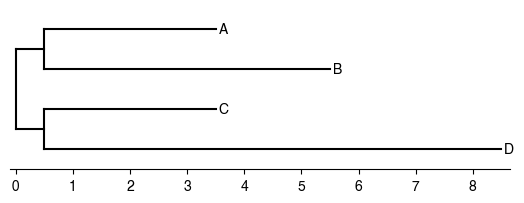

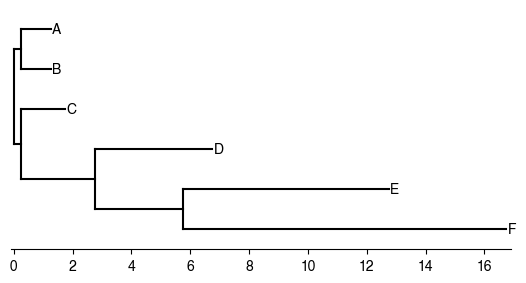

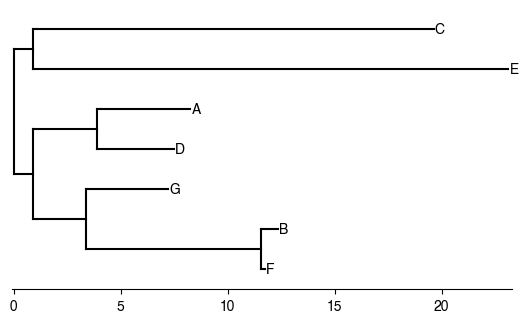

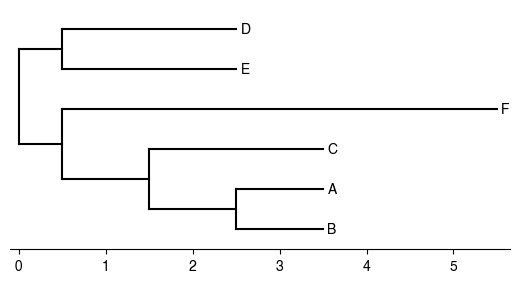

In [18]:
for matrix in [M1, M2, M3, M4]:
  if is_additive(matrix):
    tree = nj(matrix)
    print(tree.newick())
    fig, ax = tree.draw()
